# Edraak MOOC - Activity and Confidence Analysis

From data on people that participated in a MOOC (Massive Open Online Course)
we attempt to retrieve insights.
The objective is to both: analyze the data from a run of such a MOOC,
and also build a reasonably reusable tool to perform further
analysis on similar data.
We attempt to build a reasonably general data analysis tool that will
allow a user to edit a few calls to output graphs with new relations.
Also, we attempt to make the code robust enough so it does not
rust too quickly with new data and new library updates.

A conservative approach as to what libraries to use will
allow for a longer life of the code.
We only use full version libraries,
which should hence be always backward compatible with the same major version.
In our case any version of `numpy` 1, `pandas` 1 and `matplotlib` 3
shall run the code without issues.
We also avoid the `seaborn` library in order to keep the code running
for as long as possible, the `seaborn` library still has not fully
defined its interfaces.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.__version__, pd.__version__, matplotlib.__version__

('1.18.1', '1.0.1', '3.1.3')

Further we divide the work in three distinct parts.
The `jupyter` notebook in which the work is contained follow the rule
of placing dependencies above the dependent code,
hence - even if the notebook appear to be run - one needs to
run the cells above the current cell in order for the code to work.
Remember that all code state is forgotten once you shutdown `jupyter` notebook/lab,
in which case the notebook needs to be re-run.

- The *Data Model* which consist of packaging the data we have into a consistent set of tables.
  For any compatible dataset this part will need to be reworked.
  Yet, once the dataset fits into the data model further analysis parts should just work.

- *General Analysis* build the common, and rather general, graphs about the participants of the MOOC.
  We build a few graphic tools along the way, tools that will be used in the following part.

- *Extra Analysis* is the part in which one can use the tools provided in the previous part
  to build his own graphs from the given data.
  The data processing in the *Data Model* part allows for extra columns to be passed
  all the way through the processing chain, this allows to build new graphs by just adding data.

---

## Part 1: Data Model

In order to make the code as reusable as possible we establish a data model to follow.
The operations on data will build a few common names which then will never be
changed throughout the remaining of the code.
Such discipline will allow us to reuse all analysis and graphics operations on a new
set of data provided we can fit the new set into the same data model.

The model itself will consist on a fact table called `response`,
with one main foreign key called `participant_id`,
it represents the activity and responses of participants to the activity steps.
A second fact table called `step` will follow the same model,
it will have the main foreign key as `participant_id` as well.
The main dimension will be called `participant` and use `participant_id` as its primary key.
The `participant` dimension will aggregate unto itself everything we know about each
participant from all source of data.
Both `response` and `step` facts will contain a time dimension upon themselves
called `week`, a numeric and ascending value to filter against.
In the `response` fact the primary key will be the uniqueness of `participant_id`,
`week`, `step` and `question`.
And in the `step` fact the primary key will be `participant_id`, `week` and `step`.

Albeit the two fact tables seem redundant to a good extent,
the reason for the separation is that several participants may
attend the MOOC but not answer the questions.
The `response` fact accounts for more granular information on diligent participants,
whilst the `step` fact accounts for all participants,
including participants who only clicked on a few steps and gave up.

There is nothing holding the uniqueness of the keys described
since we use pandas and not a SQL database.
The onus on verifying the uniqueness is on the user.
We add a few sanity checks after the data processing for this purpose,
and these shall catch a good deal of issues if such appear.

### Current Data

In order to fit our data model we build the fact and dimension as follows:

- `participant` is built from `enrolments` data joined with the `archetype-survey`.
  the primary key `learner_id` is renamed to `participant_id`.

- `response` is constructed from the `question-response` data and joined with
  `step-activity` and aggregated `comments`.  It's foreign key `learner_id`
  is renamed to `participant_id`.

- a third fact table `comment` is built from comments data and linked to the
  `participant` dimension.  The `author_id` foreign key is renamed to `participant_id`
  for the linking purpose.  This extra table is unlikely to appear in a different
  data set hence we leave it out of the data model.  There is also no
  uniqueness (or primary key) for this data.

Note that all joins will be left joins from the `participant` dimension
onto the fact tables, thus avoiding missing data on the dimension side.

### Loading the data

**The names of the CSV files may differ**, one must remember to verify the file names,
which must live in the same directory as the notebook.
**Also note that the filenames have the name of the MOOC course removed.**
The `parse_dates=` parameters are used for date and time columns,
and allow us to work with times in an easier fashion.
Whilst the `index_col=` takes the column with unique values,
sometimes there is no column with unique values and sometimes
the unique values are just meaningless `ID` numbers.

In [2]:
import hashlib


def scramble_personal(data, hexadecimal=False):
    hexdigest = hashlib.sha1(data.encode('utf-8')).hexdigest()[:16]
    if hexadecimal:
        return hexdigest
    # 16 nibbles fit exactly in np.uint64
    return np.uint64(int(hexdigest, 16))


scramble_hex = lambda x: scramble_personal(x, hexadecimal=True)

In [3]:
profile = pd.read_csv('student-profile.csv', index_col='id')
profile['username'] = profile['username'].apply(scramble_personal)
profile['name'] = profile['name'].apply(scramble_hex)
profile['email'] = profile['email'].apply(scramble_hex)
profile.drop(['mailing_address', 'goals'], axis=1, inplace=True)
profile[:3]

,username,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country
id,,,,,,,,,,,,
3006214,12910178080571563399,d8bab5ca42234804,77aab4eae8557a75,NaN,NaN,1998,m,NaN,honor,NaN,NaN,EG
4926586,10354132342401575959,db4ba2237ac29641,315d7718b527ccdb,NaN,NaN,1992,f,NaN,honor,NaN,NaN,EG
4885163,17642583103743342069,b9df86b8035d8c03,009e0ea7ba971e8b,NaN,NaN,2000,m,NaN,honor,NaN,NaN,LB


In [4]:
collision = len(profile) - len(profile.groupby('username').size())
profile = profile.groupby('username').first().reset_index()
print(f'hash collisions {collision}')

hash collisions 0


In [5]:
import glob, re


def read_week(w, q, filename):
    week = pd.read_csv(filename)
    week = week.rename(columns={
        'إجابة': 'response',
        'username': 'participant_id',
    })
    week['week'] = w
    week['step'] = 1
    week['question'] = q
    week['participant_id'] = week.participant_id.apply(scramble_personal)
    return week[['participant_id', 'week', 'step', 'question', 'response']].dropna()


all_weeks = sorted(glob.glob('week-*'))
dfs = []
for w in all_weeks:
    groups = re.match('week-(\d+)-q-(\d+)', w).groups()
    groups = list(map(int, groups))
    groups.append(w)
    dfs.append(read_week(*groups))
week = dfs[0].append(dfs[1:])
week[:3]

,participant_id,week,step,question,response
0,17974442635216503513,1,1,1,5.0
1,15779273676961703902,1,1,1,3.0
3,1890423570833598262,1,1,1,4.0


In [6]:
groups = ['participant_id', 'week', 'step', 'question']
collision = len(week) - len(week.groupby(groups).size())
week = week.groupby(groups).first().reset_index()
print(f'hash collisions {collision}')

hash collisions 0


### Sanity Checks

A few assumptions are made about the data before we process it.
Some of these sanity checks will be repeated once we transition into
the data model specified above but the earlier we find possible issues the better.
**Each of the tests below should not fail and should return `True`.**
If that is not the case then one must go back to the files and rectify.

IDs for participants are unique.

In [7]:
len(profile.index.unique()) == len(profile)

True

Indexes such as weeks and steps must be integers.
Note that this also means that there are no null values
as `numpy` does not allow for null integers.

In [8]:
pd.api.types.is_integer_dtype(week.week)

True

In [9]:
pd.api.types.is_integer_dtype(week.step)

True

In [10]:
pd.api.types.is_integer_dtype(week.question)

True

### Transform (into the Data Model)

Now we can place the data we have into the data model we defined.
The naming convention is that we will never use the same variable
name for the loaded data and the data model table,
this naming convention ensures that columns can be re-run
without too much care for the order in which they are re-run.

In [11]:
# configuration, year the course did run
this_year = 2021

In [12]:
participant = profile.copy()
participant.loc[participant.gender.isnull(), 'gender'] = 'unknown'
participant.loc[participant.country.isnull(), 'country'] = 'unknown'
participant = participant.rename(columns={'username': 'participant_id'})
participant.set_index('participant_id', inplace=True)

def age_range(yob):
    try:
        y = int(yob)
        return (this_year - y)//10
    except ValueError:
        return np.nan

participant['age_range'] = participant.year_of_birth.apply(age_range)
participant['age_range'] = participant.age_range.fillna(int(participant.age_range.mean()))
participant['age_range'] = participant.age_range.apply(lambda x: f'{x*10:.0f}-{(x+1)*10:.0f}')
participant[:3]

,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country,age_range
participant_id,,,,,,,,,,,,
10493475746994014,949926d65939c3cc,5ca1f97efa7fd7e9,NaN,NaN,1991,m,NaN,honor,NaN,NaN,YE,30-40
14413915214086787,17ab607dd937c415,80c67bad7baf3e97,NaN,NaN,1981,m,b,honor,NaN,NaN,JO,40-50
28890453854225496,cf60ceca10f87f21,0c90e15ca67eea66,NaN,NaN,1991,m,a,honor,NaN,NaN,EG,30-40


And we can build the `participant` dimension,
while at the same time enrich it with data from the archetype survey
and the step comments.

The `participant` dimension defines all information we have about the participants,
if more data about the students themselves becomes available we can
further extend this table with more columns.

In [13]:
from collections import defaultdict


education = defaultdict(
    lambda: 'unknown',
    p='doctorate',
    m='masters or professional degree',
    b='bachelors degree',
    a='associate degree',
    hs='secondary/high school',
    jhs='junior secondary/junior high/middle school',
    el='elementary/primary school',
    none='no formal education',
    other='other education',
    p_se='doctorate in science or engineering',
    p_oth='doctorate in another field')


def make_education(e):
    if not pd.isnull(e):
        e = e.lower()
    return education[e]


participant['level_of_education'] = participant.level_of_education.apply(make_education)
participant[:3]

,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country,age_range
participant_id,,,,,,,,,,,,
10493475746994014,949926d65939c3cc,5ca1f97efa7fd7e9,NaN,NaN,1991,m,unknown,honor,NaN,NaN,YE,30-40
14413915214086787,17ab607dd937c415,80c67bad7baf3e97,NaN,NaN,1981,m,bachelors degree,honor,NaN,NaN,JO,40-50
28890453854225496,cf60ceca10f87f21,0c90e15ca67eea66,NaN,NaN,1991,m,associate degree,honor,NaN,NaN,EG,30-40


The `response` fact is the last one to add into the data model.
Here the `response` column is quite messy,
sometimes students can answer several options,
other times they can answer the same question several times.
Since we assume that all answers will be numbers
we take the mean of the students' answers in every case.

On top of the answers to the questions themselves we enrich
the `response` fact with the completion steps.
Albeit it may be redundant to check whether a student
who has answered the questions has started and completed the same MOOC week,
it may be useful to check the answers for students who gave up
and not completed the following MOOC week.

In [14]:
response = week.copy()
response['started'] = True
response['completed'] = True
response[:3]

,participant_id,week,step,question,response,started,completed
0,62904841179571038,1,1,1,3.0,True,True
1,62904841179571038,1,1,2,3.0,True,True
2,62904841179571038,1,1,3,4.0,True,True


The majority of the data is a time series,
hence the majority of comparisons are best made by self joins at a different time,
e.g. compare this week with next week.
Self joins may be tricky to read in code,
and it may therefore be quite difficult to change.
There are several unneeded condition in the code that are placed
in order to make the code robust against corner cases.
If you are changing the code please leave theses conditions be
no matter how obvious it seems that these are not needed for the data
currently processed.

### Sanity Checks (on the data model)

We can perform a second set of sanity check on the data model itself.
Again **each of the tests below should not fail and should return `True`.**
If all goes according to plan (no failures) we expect the rest
of the analysis to go smoothly.

Participant identifiers are unique.

In [15]:
len(participant.index) == len(participant.index.unique())

True

Every participant answered a question at most once.

In [16]:
response.groupby(['participant_id', 'week', 'step', 'question']).size().sum() == len(response)

True

This completes the data modeling part.
Let us say loud the assumption made about the participant that,
assumptions that allow us to mathematically reason about the data.

- Questions of interest will always have numeric values,
  where the biggest value means better and the lowest means worse.

- A participant can only be enrolled once.

- The archetype questionnaire should only be answered once.
  If a student answers the archetype questionnaire several times
  only the last set of answers is taken into account.
  (i.e. we force learner_id to be a PK for archetype)

- Question of interest will always be about a participant
  confidence in himself or some course of action.
  This allows as to make several further assumptions
  on response aggregation.

- Step question answers are only answered once.
  When several answers are performed by the same student
  we take the *mean* of the answer.  This is an assumption
  based on the fact that we are asking about a student's confidence,
  and a change of heart is part of our evaluation.

And for the current dataset we also assume a few things that
allow s to fit the data into the data model.

- Country and Video data is not of any particular interest.
  Note that enrollment data already detects a country,
  which a a more reliable source.

---

## Part 2: General Analysis

A few general graphs about the course as a whole can be performed.
Once we are done with those we start building a few tools to allow us
analysis of the information about the participant background.
If the previous steps above have all succeeded, most code cells can be run at any time.
Yet, the exception are the code cells at the end of this part,
there we define functions to be used for graphing.
**The most common error is to shutdown the notebook and then forget
to re-run the code cell containing the graphing functions before attempting the graphs.**
Beware of that.

---

# Quiz Responses

Week 1 Step 3, q -> All questions
Week 2 Step 6
Week 3 Step 7

Assumption: Every step of interest has the same number of questions.

In [17]:
# this is week 1 step 1, week 2 step 1 and week 3 step 1
confidence = [(1, 1), (2, 1), (3, 1)]

In [18]:
all_steps = []
for w, s in confidence:
    all_steps.append(response[(response.week == w) & (response.step == s)])
len(all_steps)

3

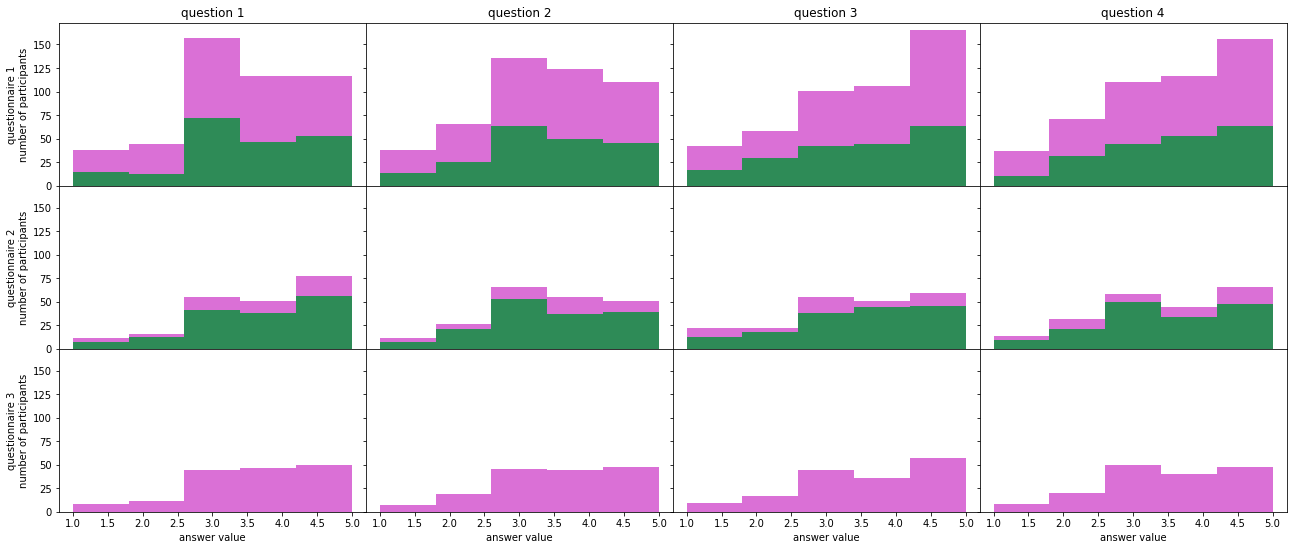

In [19]:
bins = int(response.response.max())
n_steps = len(all_steps)
n_questions = max(map(lambda x: len(x.question.unique()), all_steps))
fig, axs = plt.subplots(n_steps, n_questions, sharex=True, sharey=True, figsize=(22, n_steps*3))

for i in range(n_steps):
    for j in range(n_questions):
        this_step = all_steps[i]
        this_step = this_step[this_step.question == j + 1]
        next_step = all_steps[i+1] if i+1 < len(all_steps) else None
        ax = axs[i, j]
        ax.hist(this_step.response, bins=bins, color='orchid')
        if next_step is not None:
            next_step = next_step[['participant_id', 'question']]
            next_step = next_step[next_step.question == j + 1].copy()
            next_step.rename(columns={'question': 'next_week_question'}, inplace=True)
            qtmp = pd.merge(this_step, next_step, on='participant_id', how='inner')
            ax.hist(qtmp.response, bins=bins, color='seagreen')
        if j == 0:
            ax.set_ylabel(f'questionnaire {i+1}\nnumber of participants')
        if i == 0:
            ax.set_title(f'question {j+1}')
        if i+1 == n_steps:
            ax.set_xlabel(f'answer value')
plt.subplots_adjust(hspace=0, wspace=0)

## Graph 2

General confidence across weeks.
The difference between colors again shows how many students gave up on that week.
The scales between the three graphs are the same,
the height can be compared to account for the change in confidence.

A fair hypothesis is to say that the positive change in confidence happens at the end of the MOOC.
Students who did stay from week 1 to week 2 do not show a change in confidence.
But the students that stayed from week 2 to week 3 show a shift to the right in several places
between the tow graphs (week 2 green to week 3 indigo).

---

# Enrolled Students

In [20]:
# We could loop only once,
# but that would assume that we always have only a single step of interest per week.
# Looping several times allow for less assumptions on the data.
all_resp = []
all_resp_adv = []
for w, s in confidence:
    all_resp.append(response[(response.week == w) & (response.step == s)])

In [21]:
for i in range(len(all_resp)):
    this_resp = all_resp[i]
    next_resp = all_resp[i+1] if i+1 < len(all_resp) else None
    if next_resp is not None:
        # this grouping here is the main reason why we split into lists
        next_resp = next_resp[['participant_id', 'question', 'response']].copy()
        next_resp.rename(columns={'response': 'next_response'}, inplace=True)
        adv_step = pd.merge(this_resp, next_resp, on=['participant_id', 'question'], how='inner')
        adv_step['increase'] = adv_step.next_response - adv_step.response
        all_resp_adv.append(adv_step)
    else:
        # last element will always be empty
        df = this_resp.drop(this_resp.index)
        df['next_response'] = np.nan
        df['increase'] = .0
        all_resp_adv.append(df)

# sanity check
print('We got', len(all_resp_adv), 'questionnaires of interest')

We got 3 questionnaires of interest


In [22]:
def enrich_data(step_resp):
    enriched = pd.merge(participant, step_resp, left_index=True, right_on='participant_id', how='right')
    return enriched

all_resp = list(map(enrich_data, all_resp))
all_resp_adv = list(map(enrich_data, all_resp_adv))
# sanity check
print('And we got', len(all_resp_adv), 'questionnaires of interest')

And we got 3 questionnaires of interest


In [23]:
def half_violin(x, y, *args, ax=None, left=False, mean=None, meadian=None, color=None, alpha=None, **kwargs):
    # force a clean plot so we can add these manualy
    kwargs['showmeans'] = False
    kwargs['showextrema'] = False
    kwargs['showmedians'] = False
    # allow for lists and single values
    if type(alpha) is not list and type(alpha) is not tuple and type(alpha) is not np.ndarray:
        alpha = [alpha]*len(x)
    if type(color) is not list and type(color) is not tuple and type(color) is not np.ndarray:
        color = [color]*len(x)
    # filters out empty arrays (sanity check first)
    filtered = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    if not list(filtered):  # everything is empty, bail
        return
    x, y, color, alpha = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    params = ax.violinplot(x, y, *args, **kwargs)
    for i, b in enumerate(params['bodies']):
        if not b.get_paths():  # empty graph - violinplots do not work well with missing data
            continue
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        clips = [m, np.inf]
        if left:
            clips = [-np.inf, m]
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *clips)
        if color[i]:
            b.set_color(color[i]) 
        if alpha[i]:
            b.set_alpha(alpha[i])


def double_violin(xl, xr, y, *args, ax=None, color_left=None, color_right=None, **kwargs):
    half_violin(xl, y, *args, ax=ax, left=True, color=color_left, **kwargs)
    half_violin(xr, y, *args, ax=ax, color=color_right, **kwargs)

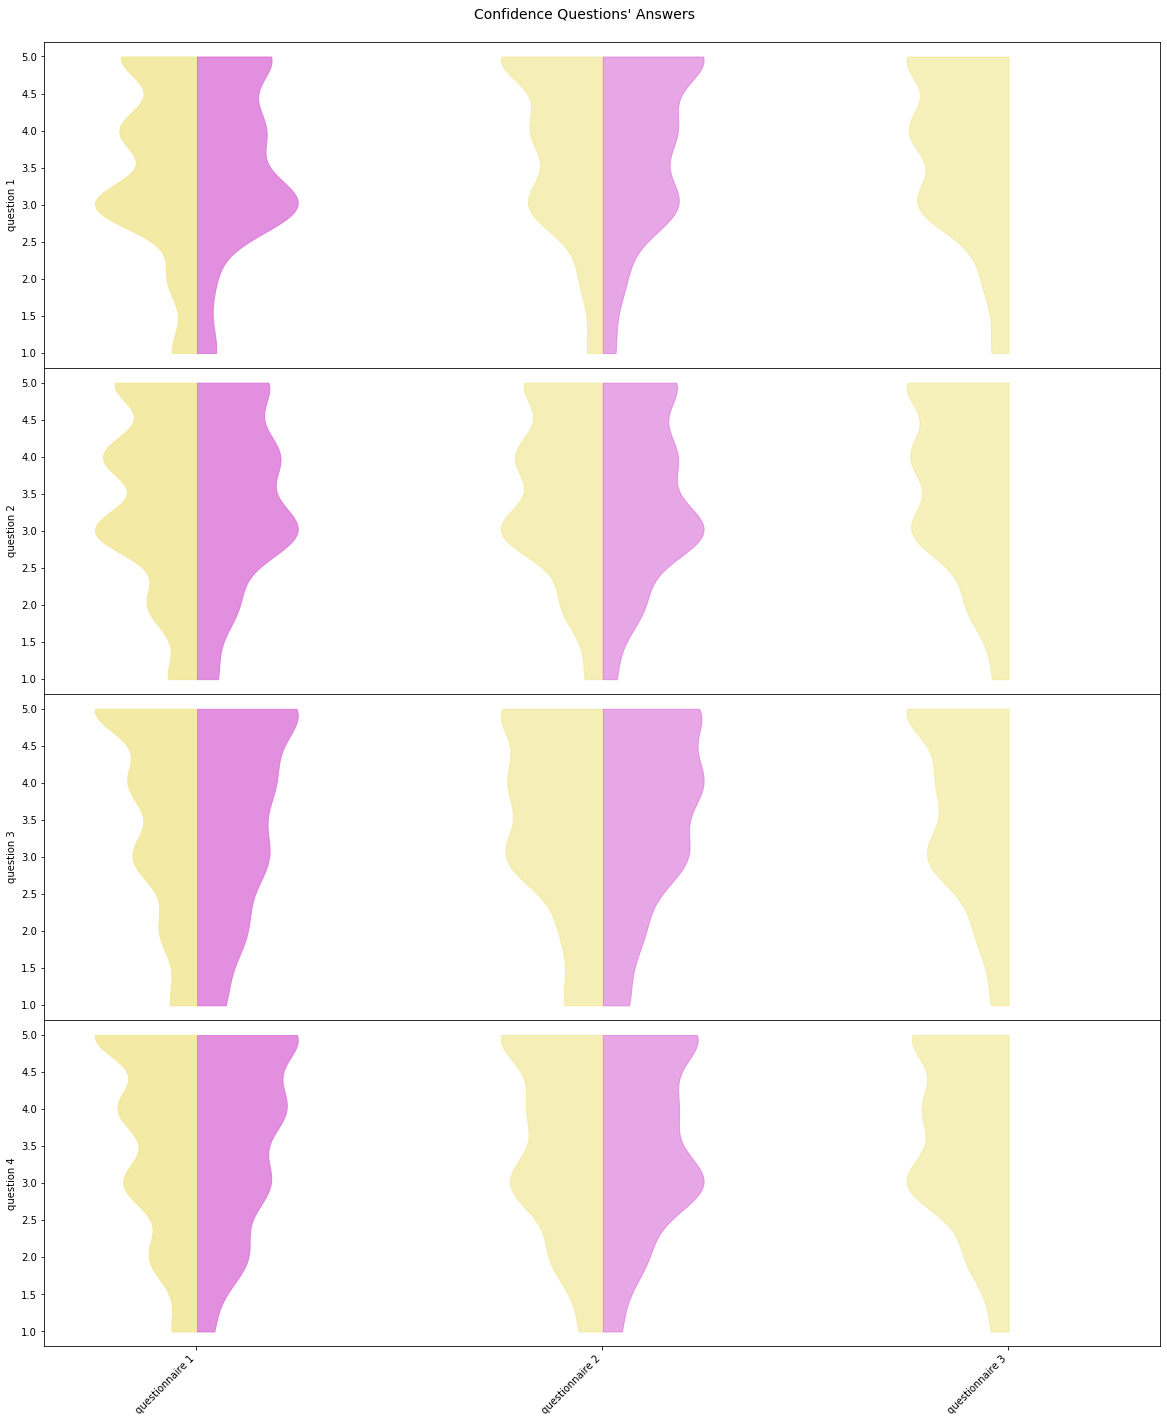

In [24]:
n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))

ticks = list(range(len(all_resp)))
labels = list(map(lambda x: f'questionnaire {x+1}', ticks))
for i in range(n_questions):
    fil = lambda x: x[x.question == i+1].response.dropna().reset_index(drop=True)
    left = list(map(fil, all_resp))
    right = list(map(fil, all_resp_adv))
    atmp = np.array(list(map(len, left)))
    alpha = atmp / (atmp.sum() * 2) + .5  # weight size for alpha values
    double_violin(left, right, ticks, ax=ax[i], color_left='khaki', color_right='orchid', alpha=alpha)
    ax[i].set_ylabel(f'question {i+1}')

ax[-1].set_xticks(ticks)
ax[-1].set_xticklabels(labels, rotation=45, ha='right')
fig.suptitle("Confidence Questions' Answers", y=.9, fontsize=14)
plt.subplots_adjust(hspace=0)

In [25]:
participant['level_of_education'].value_counts()

unknown                                       1405
bachelors degree                               677
secondary/high school                          261
masters or professional degree                 225
junior secondary/junior high/middle school      39
other education                                 36
associate degree                                34
doctorate                                       28
no formal education                              5
elementary/primary school                        4
Name: level_of_education, dtype: int64

In [26]:
# to keep things readable, we limit by 13 biggest values by default
def plot_response(stat, limit=13):
    n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
    estat = participant[stat].value_counts()
    fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))

    colors = [('khaki', 'orchid'), ('seagreen', 'firebrick')] * int(np.ceil(len(estat) / 2))
    ticks = list(range(len(all_resp)))
    complete_ticks = []
    labels = list(map(lambda x: f'questionnaire {x}', ticks))
    complete_labels = []
    walk = enumerate(estat.index)
    if limit:
        walk = list(walk)[:limit]
    for n_stat, cur_stat in walk:
        for i in range(n_questions):
            fil = lambda x: x[(x.question == i+1) & (x[stat] == cur_stat)].response.reset_index(drop=True)
            left = list(map(fil, all_resp))
            right = list(map(fil, all_resp_adv))
            # weight size for alpha values (prevent division by zero)
            atmp = np.array(list(map(len, left)))
            alpha = atmp / (atmp.sum() * 2 + .1) + .5
            cleft, cright = colors[n_stat]
            double_violin(left, right, ticks, ax=ax[i], color_left=cleft, color_right=cright, alpha=alpha)
            ax[i].set_ylabel(f'question {i+1}')
        complete_ticks += ticks
        ticks = list(map(lambda x: x+n_questions+1, ticks))
        complete_labels += list(map(lambda x: f'{cur_stat} ({estat[cur_stat]}) - ' + x, labels))

    ax[-1].set_xticks(complete_ticks);
    ax[-1].set_xticklabels(complete_labels, rotation=45, ha='right')
    fig.suptitle(stat, y=.9, fontsize=14)
    plt.subplots_adjust(hspace=0)

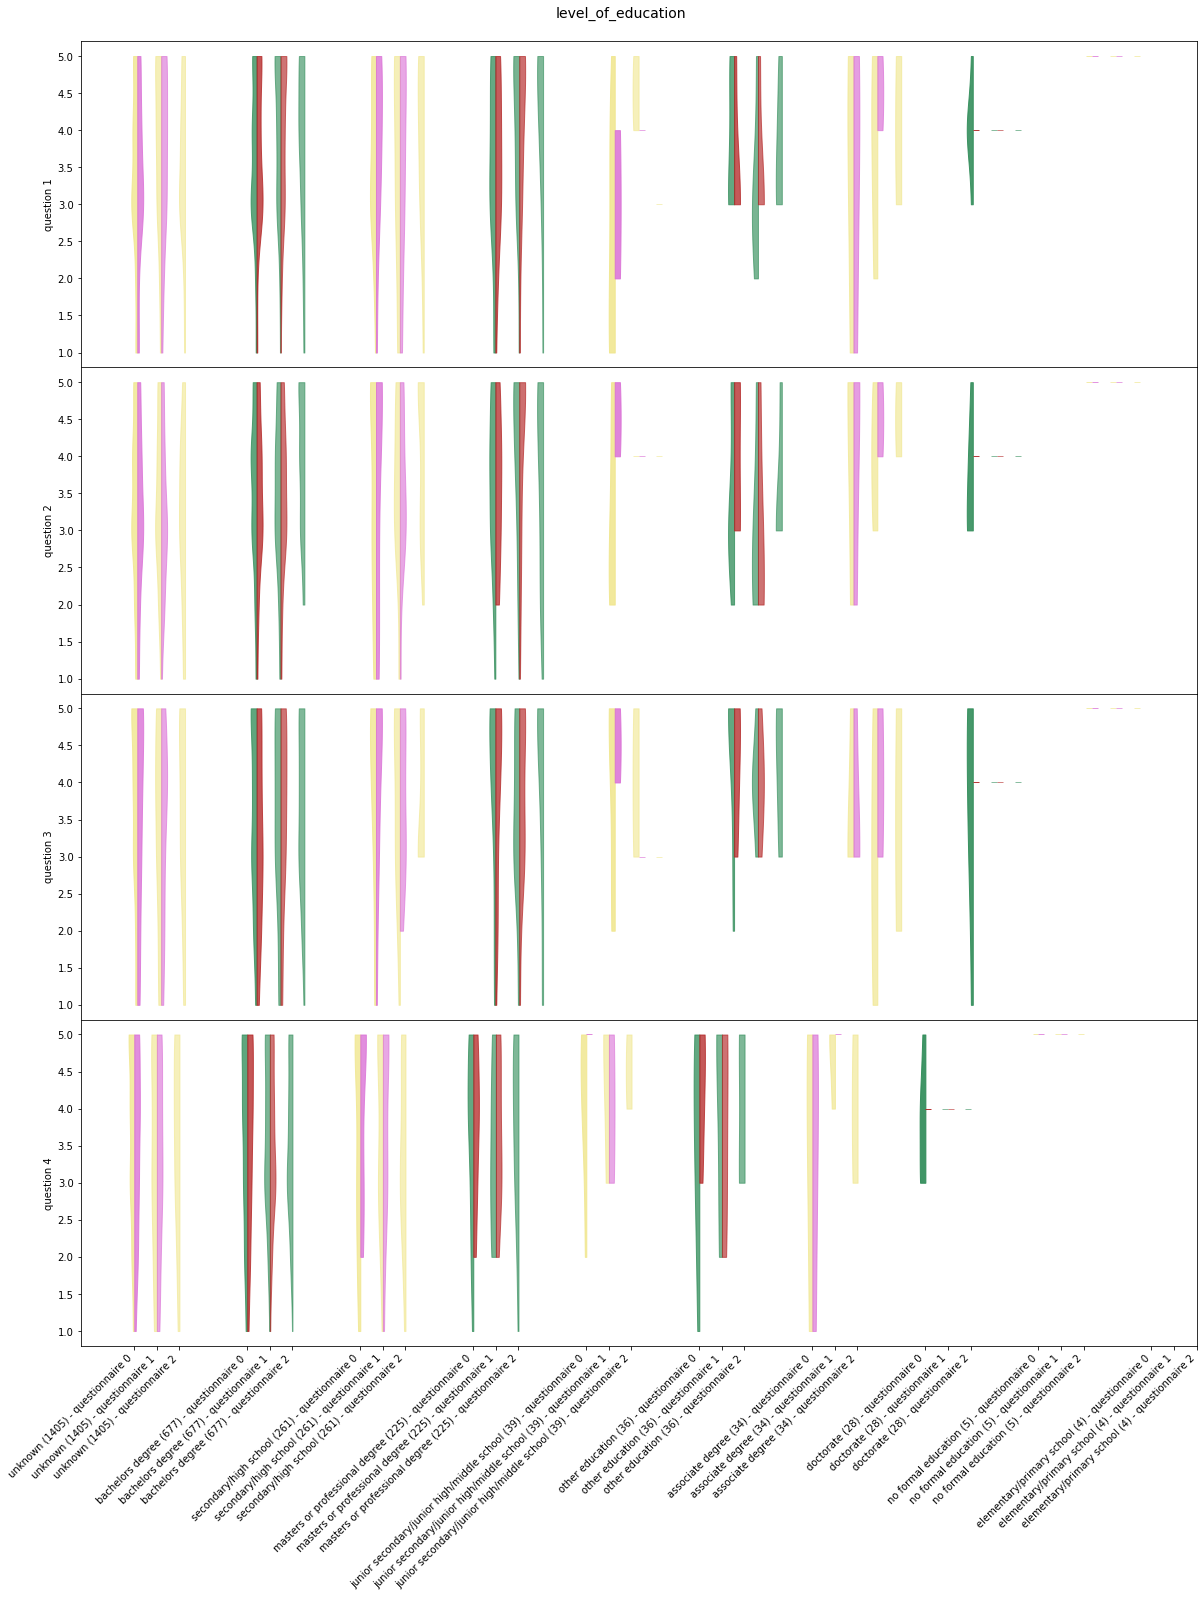

In [27]:
plot_response('level_of_education')

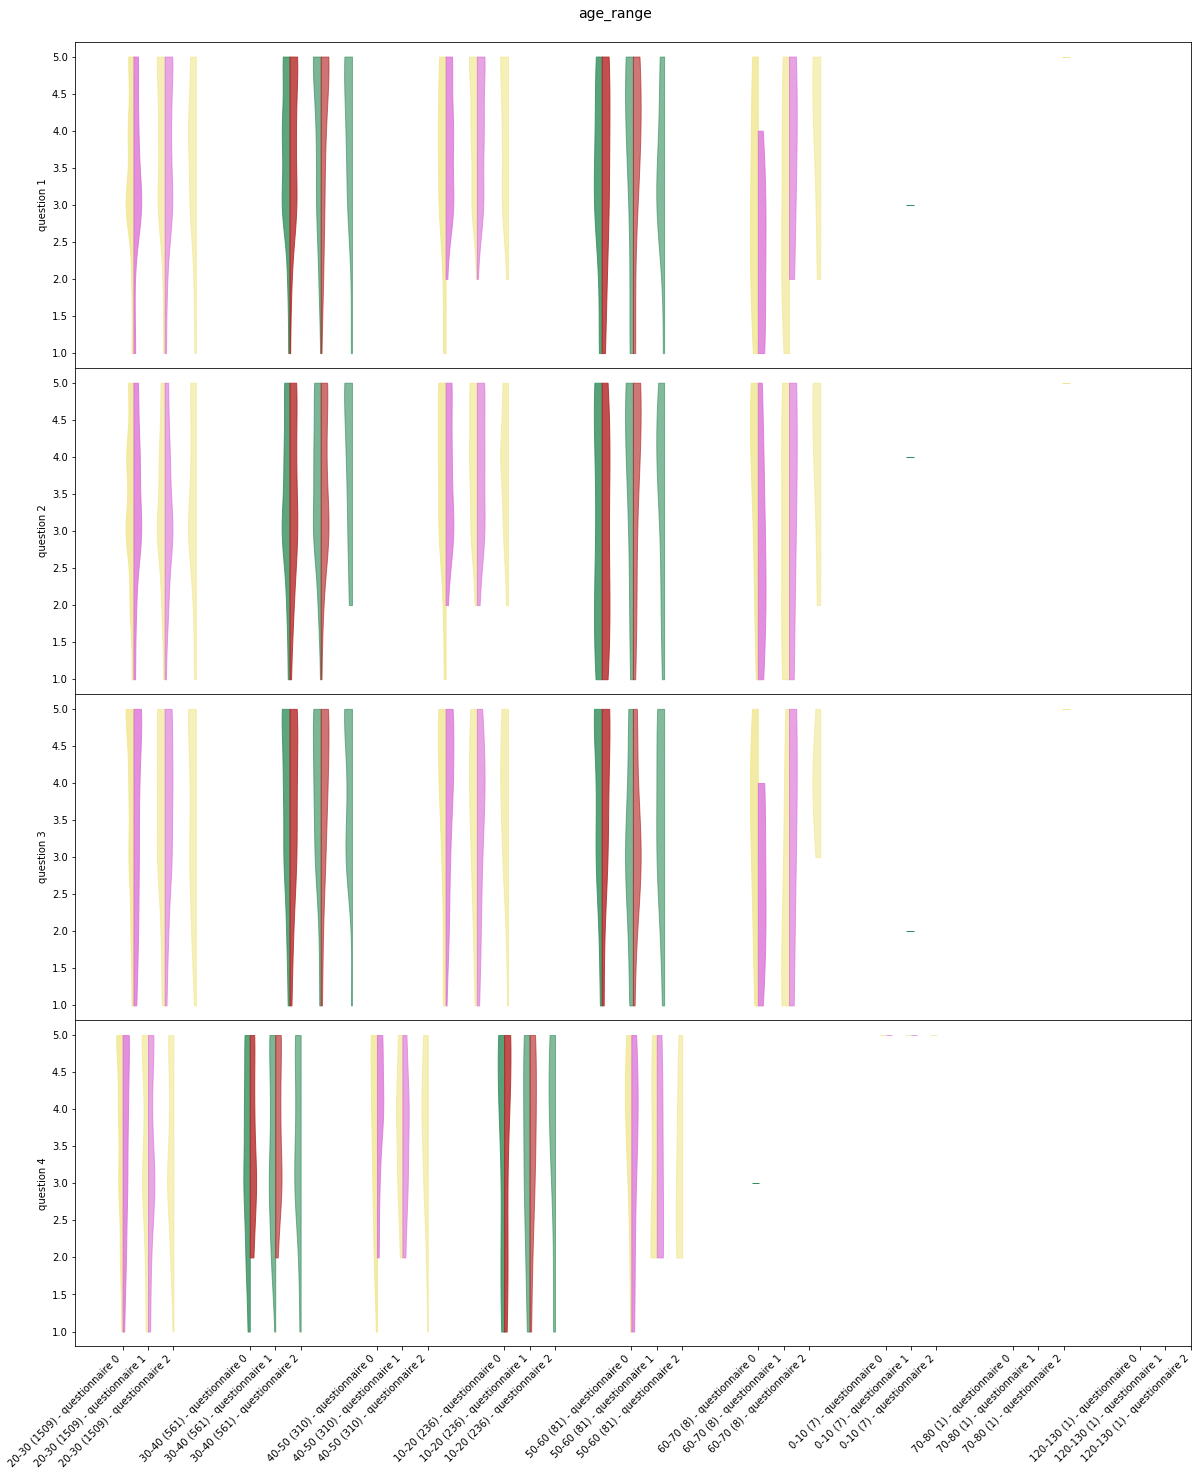

In [28]:
plot_response('age_range')

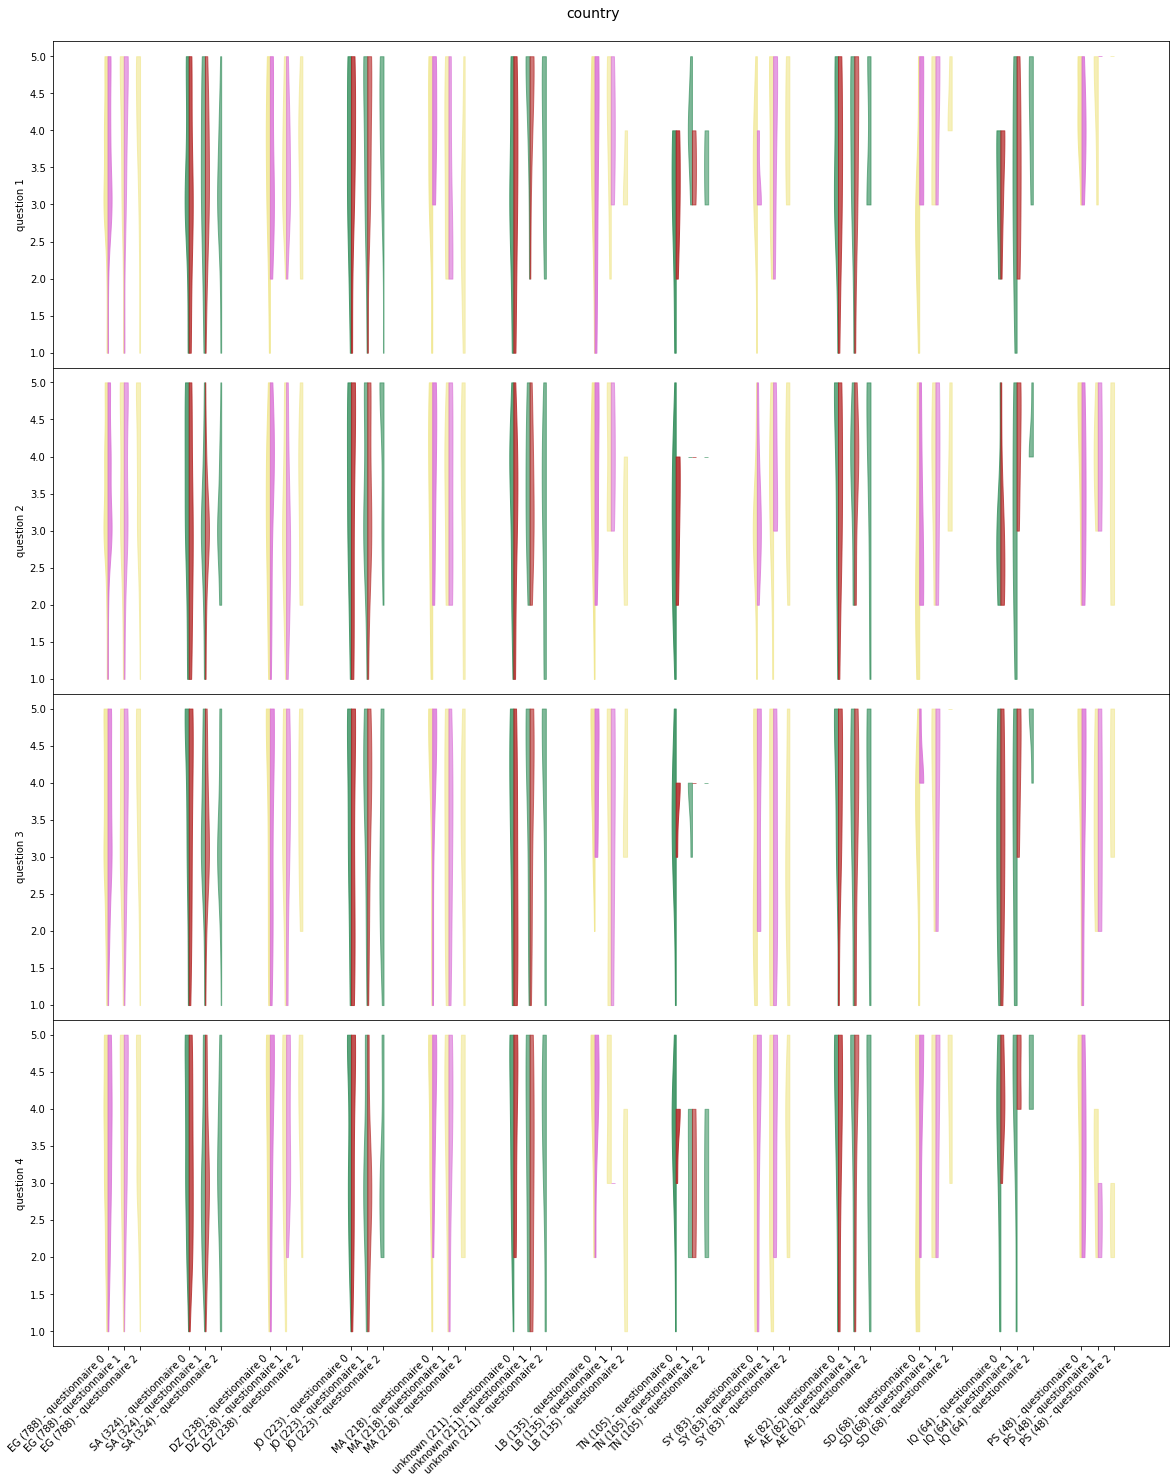

In [29]:
plot_response('country')

## Graph 3

Example of comparison graph.
Each vertical grouping is a distribution of answers by students in the label group.
Groups are always placed together for the three weeks of answers
and split (by a larger spacing between the label groups).
The ball sizes are normalized within the groups,
in this way we can compare the scatter sizes to get information about a single
label group behaviour (here employment status).
The colors are not normalized and represent the sizes of the groups.
Brighter colors (towards yellow) are the biggest groupings, here "Unknown".
Label groups with bright colors have good sample sizes,
whilst dull dark blue label groups have meaningless sample sizes.

This graph method can be reasonably easily reused.  For example, highest education level.